In [1]:
import os, sys
# sys.path.append('..')

from dig.threedgraph.dataset import rotation
import torch
import torchani
from torch_geometric.data import Data, DataLoader, InMemoryDataset
from dig.threedgraph.method import FCNN, SchNet, SphereNet
from schnet_ablation1 import SchNet_ablation1 as SchNet1
from dig.threedgraph.evaluation import ThreeDEvaluator
from run2 import run

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


dataset = rotation(root='dataset/')
target = 'U0'
dataset.data.y = dataset.data[target]


model1 = FCNN(device=device)
args_dir1 = "save_dir/valid_checkpoint19.pt"

model2 = SchNet(energy_and_force=False, cutoff=10., num_layers=6, hidden_channels=128, 
               out_channels=1, num_filters=128, num_gaussians=200).to(device)
args_dir2 = "Chkpoints/U0_QM9_best_valid_checkpoint_148.pt"

model3 = SchNet1(energy_and_force=False, cutoff=10., num_layers=6, hidden_channels=128, 
               out_channels=1, num_filters=128, num_gaussians=200).to(device)
args_dir3 = 'Chkpoints/U0_QM9_ablation1_best_valid_checkpoint_115.pt'

model4 = SphereNet(
                energy_and_force = False,
                cutoff = 5.,
                num_layers = 6,
                hidden_channels = 128,
                out_channels = 1,
                int_emb_size = 64,
                basis_emb_size_dist = 8,
                basis_emb_size_angle=8, 
                basis_emb_size_torsion=8, 
                out_emb_channels=256,
                num_spherical=3, 
                num_radial=6, 
                envelope_exponent=5,
                num_before_skip=1, 
                num_after_skip=2, 
                num_output_layers=3
            ).to(device)
args_dir4 = 'Chkpoints/sphereNet.pt'

state_dict1 = torch.load(args_dir1)['model_state_dict']
model1.load_state_dict(state_dict1)

state_dict2 = torch.load(args_dir2)['model_state_dict']
model2.load_state_dict(state_dict2)

state_dict3 = torch.load(args_dir3)['model_state_dict']
model3.load_state_dict(state_dict3)

state_dict4 = torch.load(args_dir4)['model_state_dict']
model4.load_state_dict(state_dict4)

loss_func = torch.nn.L1Loss()
evaluation = ThreeDEvaluator()

run3d = run()
# run3d.run(device, train_dataset, valid_dataset, test_dataset, model, loss_func, evaluation,
#           epochs=10, batch_size=32, vt_batch_size=32, lr=0.001, lr_decay_factor=0.8, lr_decay_step_size=1,
#           energy_and_force=False, p=None, save_dir='save_dir', log_dir='log_dir')

batch_size=37
loader = DataLoader(dataset, batch_size, shuffle=False)

test_mae1, out_dic1 = run3d.val(model1, loader, False, 0, evaluation, device)
test_mae2, out_dic2 = run3d.val(model2, loader, False, 0, evaluation, device)
test_mae3, out_dic3 = run3d.val(model3, loader, False, 0, evaluation, device)
test_mae4, out_dic4 = run3d.val(model4, loader, False, 0, evaluation, device)


/home/jingdan/apps/miniconda3/envs/dig/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/jingdan/apps/miniconda3/envs/dig/lib/python3.11/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
/home/jingdan/Gdrive_temp/Data_pro/dig/threedgraph/dataset/rotation.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects w

/home/jingdan/apps/miniconda3/envs/dig/lib/python3.11/site-packages/torchani/resources/


/tmp/ipykernel_13153/2688317141.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict1 = torch.load(args_dir1)['model_state_dict']
/tmp/ipykernel_13153/2688317141.

In [2]:
pred_arr1 = out_dic1['y_pred'].cpu().detach().numpy()
true_arr = out_dic1['y_true'].cpu().detach().numpy()
pred_arr2 = out_dic2['y_pred'].cpu().detach().numpy()
pred_arr3 = out_dic3['y_pred'].cpu().detach().numpy()
pred_arr4 = out_dic4['y_pred'].cpu().detach().numpy()

In [3]:
norm_pred1 = (pred_arr1 - min(pred_arr1)) 
norm_pred2 = (pred_arr2 - min(pred_arr2)) 
norm_pred3 = (pred_arr3 - min(pred_arr3))
norm_pred4 = (pred_arr4 - min(pred_arr4))
norm_true = (true_arr - min(true_arr)) * 27.2114

In [4]:
# bias1 = abs(norm_pred1 - norm_true)
# bias2 = abs(norm_pred2 - norm_true)
# bias3 = abs(norm_pred3 - norm_true)

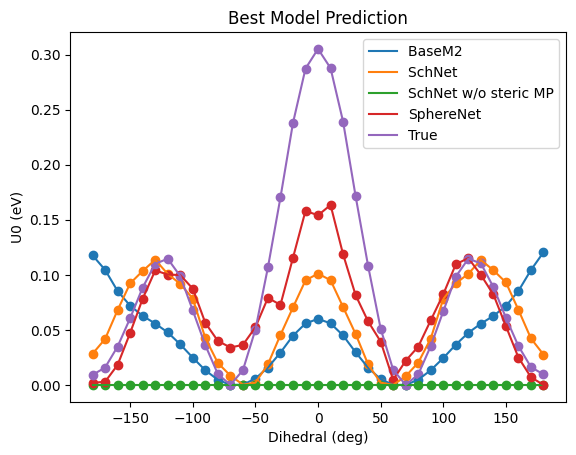

In [5]:
import matplotlib.pyplot as plt
X_list = [i*10-180 for i in range(len(norm_pred1))]
plt.scatter(X_list, norm_pred1)
plt.scatter(X_list, norm_pred2)
plt.scatter(X_list, norm_pred3)
plt.scatter(X_list, norm_pred4)
plt.scatter(X_list, norm_true)


plt.plot(X_list, norm_pred1, label='BaseM2 ')
plt.plot(X_list, norm_pred2, label='SchNet ')
plt.plot(X_list, norm_pred3, label='SchNet w/o steric MP')
plt.plot(X_list, norm_pred4, label='SphereNet')
plt.plot(X_list, norm_true, label='True')
plt.xlabel('Dihedral (deg)')
plt.ylabel('U0 (eV)')
plt.title('Best Model Prediction')
# plt.legend()
# legend position left top
plt.legend(loc='upper right')


In [6]:
# plt.scatter(X_list, bias1)
# plt.scatter(X_list, bias2)
# plt.plot(X_list, bias1, label='FCNN Bias')
# plt.plot(X_list, bias2, label='SchNet Bias')
# plt.xlabel('Dihedral (deg)')
# plt.ylabel('ΔU0 (eV)')
# plt.legend()